# AIA Temperature Response Functions
In this notebook, we'll use the code already on my PR branch to first calculate the wavelength response functions. Then, we'll try to use CHIANTI and ChiantiPy to calculate the temperature response functions for a few ions. 

We need to come up with a way to easily constrain how many wavelengths (or more precisely which ions) we need for each channel. We can certainly just search through every ion but this takes time!

In [15]:
import json

import numpy as np
import h5py
import seaborn as sns
from scipy.interpolate import splev,splrep
import matplotlib.pyplot as plt
import astropy.units as u
from sunpy.instr import aia
import ChiantiPy.core as ch
import ChiantiPy.tools.data as ch_data

%matplotlib inline

## Wavelength Response

In [2]:
response = aia.Response(ssw_path='/Users/willbarnes/Documents/Rice/Research/ssw/',
                        #channel_list=[131,171,193,211,304]
                       )

In [7]:
response.calculate_wavelength_response(include_crosstalk=True)

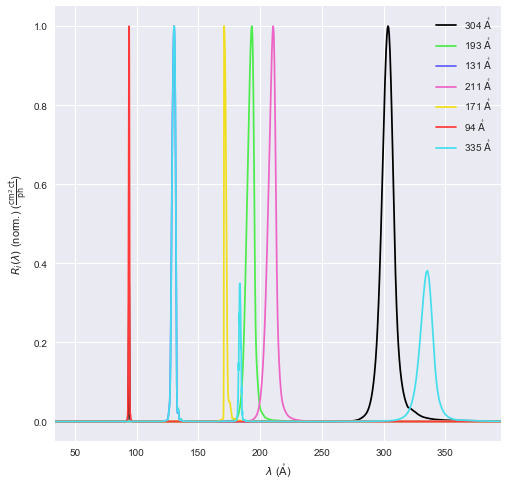

In [8]:
response.peek_wavelength_response()

In [9]:
data = np.loadtxt('../aia_sample_data/aia_wresponse_raw.dat')
channels = sorted(list(response.wavelength_response.keys()))
ssw_results = {}
for i in range(len(channels)):
    ssw_results[channels[i]] = {'wavelength':data[:,0],
                                'response':data[:,i+1]}

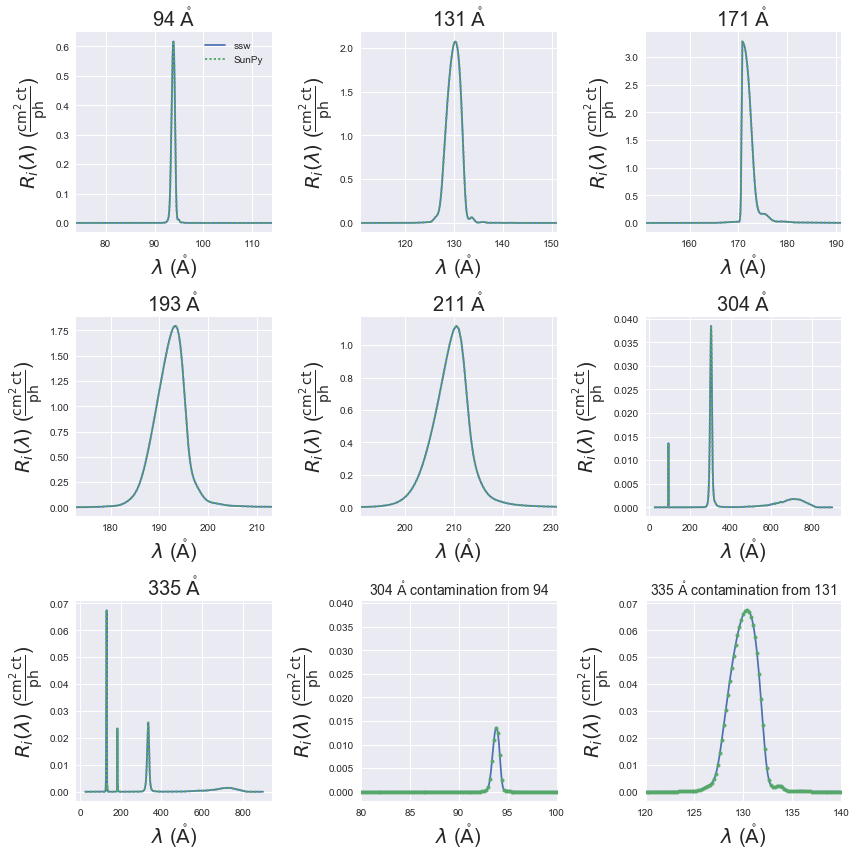

In [10]:
fig,axes = plt.subplots(3,3,figsize=(12,12))
for c,ax in zip(channels,axes.flatten()):
    #ssw
    ax.plot(ssw_results[c]['wavelength'],ssw_results[c]['response'],
            #color=response.channel_colors[c],
            label='ssw')
    #sunpy
    ax.plot(response.wavelength_response[c]['wavelength'],response.wavelength_response[c]['response'],
            #color=response.channel_colors[c],
            #marker='.',ms=6,markevery=5,
            label='SunPy',linestyle=':',alpha=0.95,lw=2)
    if c!=335 and c!=304:
        ax.set_xlim([c-20,c+20])
    #if c==335:
    #    ax.set_xlim([120,140])
    #if c==304:
    #    ax.set_xlim([80,100])
    ax.set_title('{} $\mathrm{{\mathring{{A}}}}$'.format(c),fontsize=20)
    ax.set_xlabel(r'$\lambda$ ({0:latex})'.format(response.wavelength_response[c]['wavelength'].unit),fontsize=20)
    ax.set_ylabel(r'$R_i(\lambda)$ ({0:latex})'.format(response.wavelength_response[c]['response'].unit),fontsize=20)
# contamination plots
#304
#ssw
ax = axes.flatten()[-2]
ax.plot(ssw_results[304]['wavelength'],ssw_results[304]['response'],
        #color=response.channel_colors[c],
        label='ssw')
#sunpy
ax.plot(response.wavelength_response[304]['wavelength'],response.wavelength_response[304]['response'],
        label='SunPy',linestyle='',alpha=0.95,lw=2,
        #color=response.channel_colors[c],
        marker='.',ms=8,markevery=2,
       )
ax.set_xlim([80,100])
ax.set_title('{} $\mathrm{{\mathring{{A}}}}$ contamination from 94'.format(304),fontsize=14)
ax.set_xlabel(r'$\lambda$ ({0:latex})'.format(response.wavelength_response[c]['wavelength'].unit),fontsize=20)
ax.set_ylabel(r'$R_i(\lambda)$ ({0:latex})'.format(response.wavelength_response[c]['response'].unit),fontsize=20)
#335
ax = axes.flatten()[-1]
ax.plot(ssw_results[335]['wavelength'],ssw_results[335]['response'],
        #color=response.channel_colors[c],
        label='ssw')
#sunpy
ax.plot(response.wavelength_response[335]['wavelength'],response.wavelength_response[335]['response'],
        label='SunPy',linestyle='',alpha=0.95,lw=2,
        #color=response.channel_colors[c],
        marker='.',ms=8,markevery=2,
       )
ax.set_xlim([120,140])
ax.set_title('{} $\mathrm{{\mathring{{A}}}}$ contamination from 131'.format(335),fontsize=14)
ax.set_xlabel(r'$\lambda$ ({0:latex})'.format(response.wavelength_response[c]['wavelength'].unit),fontsize=20)
ax.set_ylabel(r'$R_i(\lambda)$ ({0:latex})'.format(response.wavelength_response[c]['response'].unit),fontsize=20)
axes[0,0].legend(loc='best')
plt.tight_layout()

/Users/willbarnes/anaconda/envs/sunpy-aia-response/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


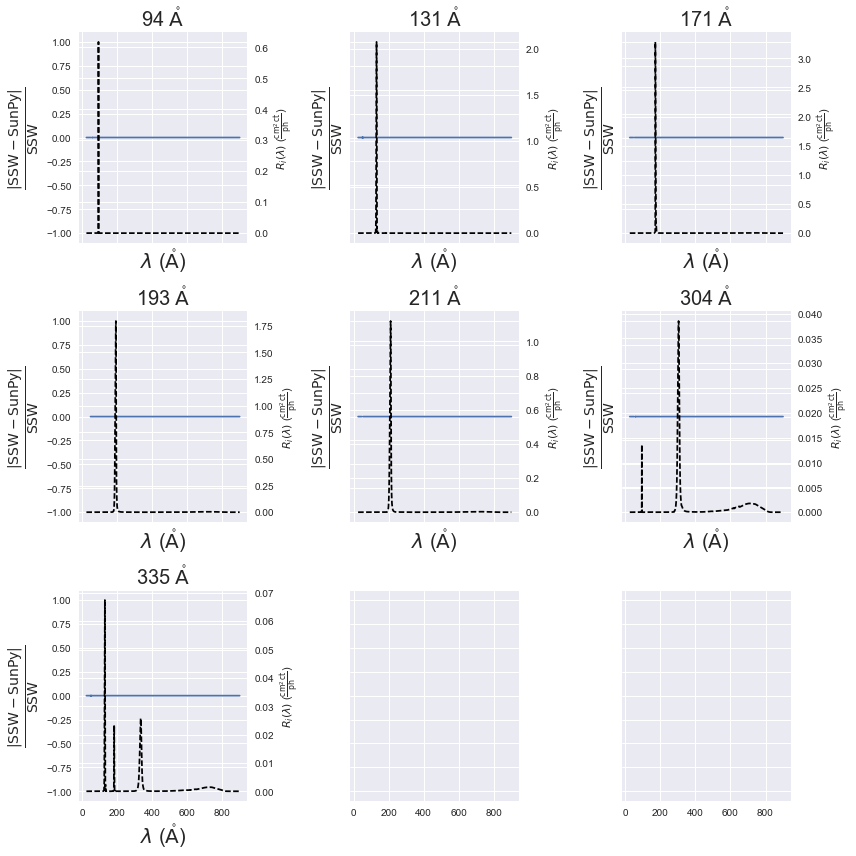

In [11]:
fig,axes = plt.subplots(3,3,figsize=(12,12),sharey=True,sharex=True)
for c,ax in zip(channels,axes.flatten()):
    #ssw
    ax2 = ax.twinx()
    ssw_interp = ssw_results[c]['response']*response.wavelength_response[c]['response'].unit
    delta_response = np.fabs(response.wavelength_response[c]['response'] - ssw_interp)/(ssw_interp)
    ax.plot(response.wavelength_response[c]['wavelength'],delta_response,
            #color=response.channel_colors[c]
           )
    ax2.plot(response.wavelength_response[c]['wavelength'],response.wavelength_response[c]['response'],
            color='k',linestyle='--')
    ax.set_title('{} $\mathrm{{\mathring{{A}}}}$'.format(c),fontsize=20)
    ax.set_xlabel(r'$\lambda$ ({0:latex})'.format(response.wavelength_response[c]['wavelength'].unit),fontsize=20)
    ax.set_ylabel(r'$\frac{|\mathrm{SSW}-\mathrm{SunPy}|}{\mathrm{SSW}}$',fontsize=20)
    ax2.set_ylabel(r'$R_i(\lambda)$ ({0:latex})'.format(response.wavelength_response[c]['response'].unit))
    ax.set_ylim([-1.1,1.1])
plt.tight_layout()

In [12]:
info_table = aia.response.aia_instr_properties_to_table([94,131,171,193,211,335],
                        ['/Users/willbarnes/Documents/Rice/Research/ssw/sdo/aia/response/aia_V6_all_fullinst.genx'])

## Temperature Response

Set a temperature and density range. This is the range of temperatures and densities over which the contribution function for each ion will be calculated. Note that this is **not** a grid of temperatures and densities, but rather a list of $T$ and $n$ pairs.

According to Boerner et al. (2012), we should use a constant pressure of $10^{15}$ cm$^{-3}$ K.

In [13]:
temperature = np.logspace(5,8,50)*u.K
pressure = 1e15*u.K*u.cm**(-3)
density = pressure/temperature

The main question is: how exactly do we calculate the temperature response functions? According to Boerner et al. (2012), the response function $K$ for channel $i$ is given by,
$$
K_i(T) = \int_0^{\infty}\mathrm{d}\lambda\,G(\lambda,T)R_i(\lambda)
$$
where $K$ has units DN cm$^{-5}$ s$^{-1}$ pix$^{-1}$. So what is the right expression for $G(\lambda,n,T)$, the contribution function? 

Let's divide the contribution function into a line emission part and a continuum part such that,
$$
G(\lambda,T) = G_{continuum}(\lambda,T) + \sum_XG_X(\lambda,T)
$$

where $X$ denotes an ion in the CHIANTI database. In this way, the response for each channel becomes,

$$
\begin{align}
K_i(T) &= \int_0^{\infty}\mathrm{d}\lambda\,\big(G_{continuum}(\lambda,T) + \sum_XG_X(\lambda,T)\big)R_i(\lambda) \\
       &= \int_0^{\infty}\mathrm{d}\lambda\,G_{continuum}(\lambda,T)R_i(\lambda) + \sum_X\int_0^{\infty}\mathrm{d}\lambda\,G_X(\lambda,T)R_i(\lambda)
\end{align}
$$

So there is a contribution from the continuum plus a contribution from each ion at every wavelength where there is a spectral line. In particular, the continuum includes three different contributions: free-free losses, free-bound losses, and two-photon losses,

$$
G_{continuum}(\lambda,T) = G_{ff}(\lambda,T) + G_{fb}(\lambda,T) + G_{tp}(\lambda,T)
$$

The expressions for these losses can be found in [Landi et al. (1999)](http://adsabs.harvard.edu/abs/1999A%26AS..135..339L). These are calculated and summed over each ion as well. Thus, the full expression for the temperature response is given by,

$$
K_i(T) = \int_0^{\infty}\mathrm{d}\lambda\,(G_{ff}(\lambda,T) + G_{fb}(\lambda,T)R_i(\lambda) + G_{tp}(\lambda,T)) + \sum_X\int_0^{\infty}\mathrm{d}\lambda\,G_X(\lambda,T)R_i(\lambda)
$$

Make a list of ions. Exactly what ions should be included is not really clear. Certainly, at least all ions of Fe. Really though, just look at all the ions in CHIANTI. Though, the user should have a chance to select which ions are included so that they can easily calculate the response functions, given only a few lines/ions.

In [ ]:
ion_list = (['fe_{}'.format(i) for i in np.arange(6,26)] 
            + ['ca_{}'.format(i) for i in np.arange(10,20)])

Boerner et al. (2012) use the coronal abundances of Feldman and Widing (1993) and the ionization balances of Dere et al. (2009). We also want to make sure we are calculating all of the emissivities in units of photons rather than ergs as this makes it easier when multiplying by the instrument response function.

In [14]:
ch_data.Defaults['flux'] = 'photon'
ch_data.Defaults['abundfile'] = 'sun_coronal_1992_feldman'
ch_data.Defaults['ioneqfile'] = 'chianti'

Now iterate through the ion list, calculating the emission and subsequently the contribution function at each stage and then interpolating the wavelength response function to the appropriate wavelengths.

Not that for the line emission, we are using the expression,

$$
G_X(\lambda,T) = \frac{1}{4\pi}\epsilon_X(\lambda,T)\mathrm{Ab}(X)\frac{N(X^{+m}}{N(X)}\frac{1}{n_e}
$$

which has units of photons cm$^{3}$ s$^{-1}$ sr$^{-1}$. The factor of $1/4\pi$ is included in the expression return by the `emiss()` method on the ChiantiPy `ion` object.

In [43]:
temperature_responses = {k:np.zeros(len(temperature)) for k in response.wavelength_response}

In [44]:
for ion in ch_data.MasterList:
    #if ion.split('_')[0] != 'fe':
    #    continue
    print('{}: Calculating contribution function for {}'.format(ch_data.MasterList.index(ion),ion))
    #declare ion object
    tmp = ch.ion(ion,temperature=temperature.value,eDensity=density.value,
                 abundance='sun_coronal_1992_feldman')
    #calculate emissivity
    tmp.emiss()
    em = tmp.Emiss['emiss'][np.argsort(tmp.Emiss['wvl']),:]
    wvl = np.sort(tmp.Emiss['wvl'])
    #calculate contribution function.
    gofnt = tmp.Abundance*em*tmp.IoneqOne/tmp.EDensity
    #iterate over channels
    for channel in response.wavelength_response:
        #print('Adding to channel {}'.format(channel))
        #interpolate response function to transitions
        rsp = splev(wvl,splrep(response.wavelength_response[channel]['wavelength'].value,
                               response.wavelength_response[channel]['response'].value))
        rsp = np.where(rsp<0,0,rsp)*response._channel_info[channel]['plate_scale'].value
        #weighted sum over wavelength
        #add to temperature response
        temperature_responses[channel] += np.dot(rsp,gofnt)

0: Calculating contribution function for h_1
1: Calculating contribution function for he_2
2: Calculating contribution function for c_6
3: Calculating contribution function for n_7
4: Calculating contribution function for o_8
5: Calculating contribution function for ne_10
6: Calculating contribution function for na_11
7: Calculating contribution function for mg_12
8: Calculating contribution function for al_13
9: Calculating contribution function for si_14
10: Calculating contribution function for p_15
11: Calculating contribution function for s_16
12: Calculating contribution function for cl_17
13: Calculating contribution function for ar_18
14: Calculating contribution function for k_19
15: Calculating contribution function for ca_20
16: Calculating contribution function for fe_26
17: Calculating contribution function for ni_28
18: Calculating contribution function for he_1
19: Calculating contribution function for c_5
20: Calculating contribution function for n_6
21: Calculating con

In [110]:
# ssw responses
precalculated_responses_data = np.loadtxt('../aia_sample_data/aia_tresponse_raw.dat')
precalc_channels = [94,131,171,193,211,304,335]
precalculated_responses = {c: precalculated_responses_data[:,i+1] for i,c in enumerate(precalc_channels)}
precalculated_responses['temperature'] = precalculated_responses_data[:,0]
# ssw responses with chiantifix and evenorm fix
precalculated_responses_data = np.loadtxt('../aia_sample_data/aia_tresponse_fix.dat')
precalculated_responses_fix = {c: precalculated_responses_data[:,i+1] for i,c in enumerate(precalc_channels)}
precalculated_responses_fix['temperature'] = precalculated_responses_data[:,0]

In [111]:
channel_colors = {c: sns.color_palette('Set2',7)[i] for i,c in enumerate(response.wavelength_response)}

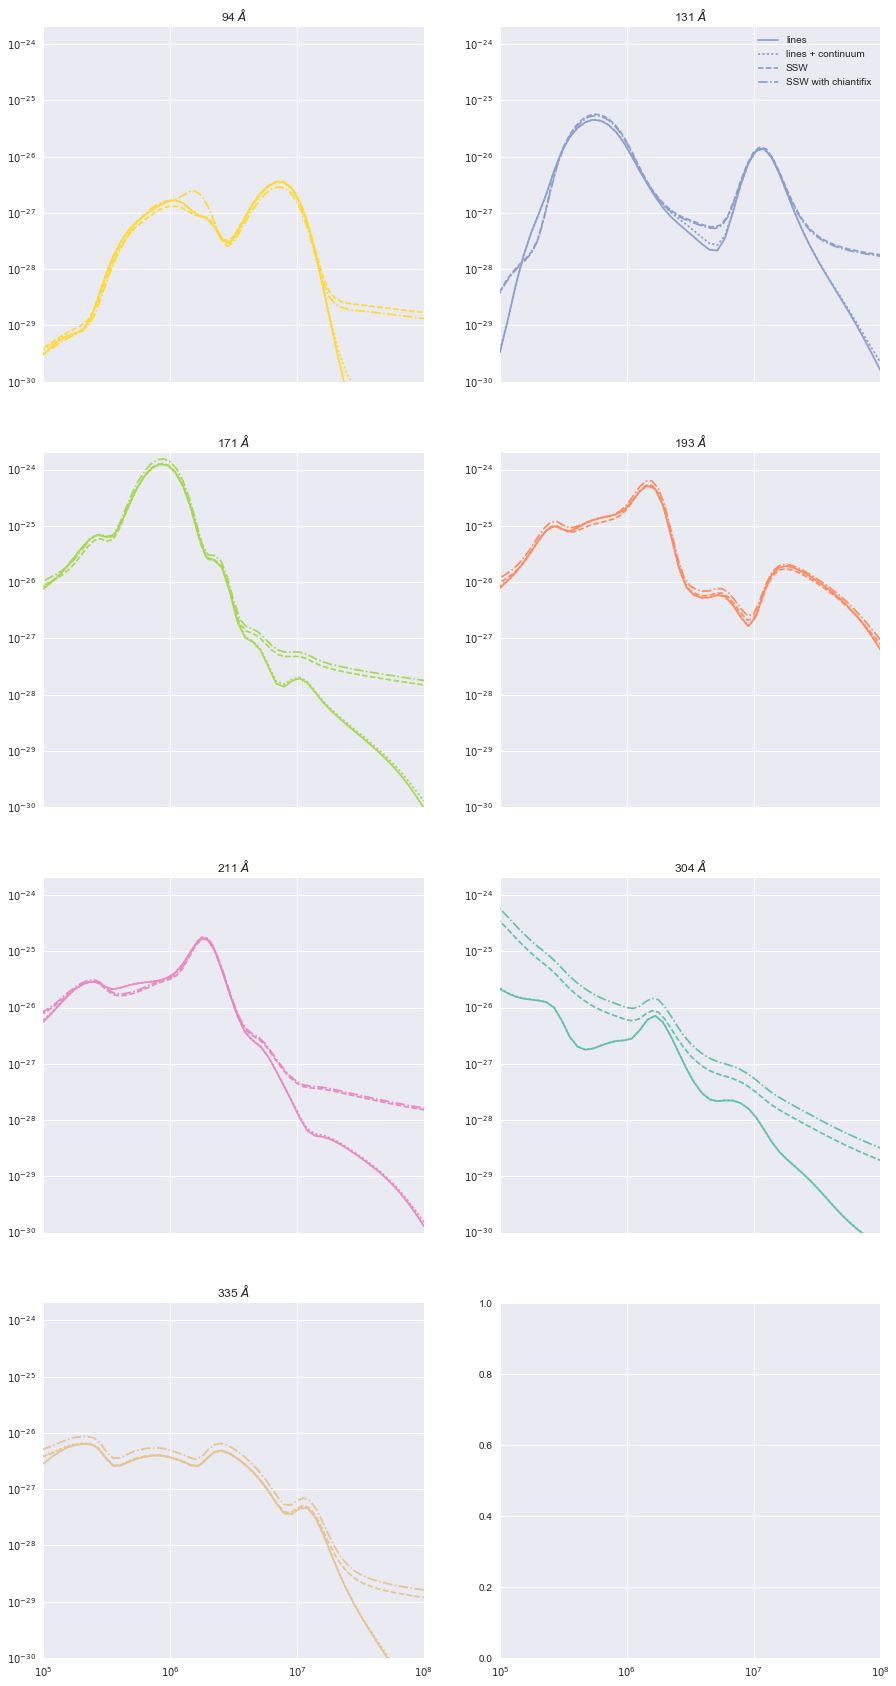

In [116]:
fig,axes = plt.subplots(4,2,figsize=(15,30),sharex=True)
for channel,ax in zip(sorted(list(temperature_responses.keys())),axes.flatten()):
    ax.plot(temperature,temperature_responses[channel]/(0.83*(1./4./np.pi)),
             label=r'lines',
             color=channel_colors[channel])
    ax.plot(temperature,(temperature_responses[channel]/(0.83*(1./4./np.pi))
                          + continuum_contributions[channel]),
             linestyle=':',
             label='lines + continuum',
             color=channel_colors[channel])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-30,2e-24])
    ax.set_xlim([1e5,1e8])
    ax.set_title(r'{} $\AA$'.format(channel))
    
for i,pc in enumerate(precalc_channels):
    axes.flatten()[i].plot(10**precalculated_responses['temperature'],
                            precalculated_responses[pc],
                            linestyle='--',
                            label=r'SSW',
                            color=channel_colors[pc])
    axes.flatten()[i].plot(10**precalculated_responses_fix['temperature'],
                        precalculated_responses_fix[pc],
                        linestyle='-.',
                        label=r'SSW with chiantifix',
                        color=channel_colors[pc])
axes[0,1].legend(loc='best')

In [61]:
continuum_contributions = {k:np.zeros(len(temperature)) for k in response.wavelength_response}

In [62]:
wvl = response.wavelength_response[94]['wavelength'].value
for ion in ch_data.MasterList:
    #if ion.split('_')[0] != 'fe':
    #    continue
    print('{}: Calculating contribution function for {}'.format(ch_data.MasterList.index(ion),ion))
    tmp = ch.ion(ion,temperature=temperature.value,eDensity=density.value,abundance='sun_coronal_1992_feldman')
    #two photon emiss
    tmp.twoPhoton(wvl)
    if 'rate' in tmp.TwoPhoton:
        two_photon = tmp.TwoPhoton['rate']
    else:
        two_photon = tmp.TwoPhoton['emiss']
    #free-free
    tmp_cont = ch.continuum(ion,temperature.value,abundance='sun_coronal_1992_feldman')
    if tmp_cont.Ion > 1:
        tmp_cont.freeFree(wvl)
        if 'rate' in tmp_cont.FreeFree:
            free_free = tmp_cont.FreeFree['rate']
        else:
            free_free = np.zeros((len(temperature),len(wvl)))
    else:
        free_free = np.zeros((len(temperature),len(wvl)))
    #free-bound
    if tmp_cont.Ion > 1:
        tmp_cont.freeBound(wvl)
        if 'rate' in tmp_cont.FreeBound:
            free_bound = tmp_cont.FreeBound['rate']
        else:
            free_bound = np.zeros((len(temperature),len(wvl)))
    else:
        free_bound = np.zeros((len(temperature),len(wvl)))
    #add to channels
    for channel in response.wavelength_response:
        continuum_contributions[channel] += np.dot((two_photon + free_free + free_bound),
                                                   (response.wavelength_response[channel]['response'].value
                                                    *response._channel_info[channel]['plate_scale'].value))

0: Calculating contribution function for h_1
1: Calculating contribution function for he_2
2: Calculating contribution function for c_6
3: Calculating contribution function for n_7
4: Calculating contribution function for o_8
5: Calculating contribution function for ne_10
6: Calculating contribution function for na_11
7: Calculating contribution function for mg_12
8: Calculating contribution function for al_13
9: Calculating contribution function for si_14
10: Calculating contribution function for p_15
11: Calculating contribution function for s_16
12: Calculating contribution function for cl_17
13: Calculating contribution function for ar_18
14: Calculating contribution function for k_19
15: Calculating contribution function for ca_20
16: Calculating contribution function for fe_26


/Users/willbarnes/anaconda/envs/sunpy-aia-response/lib/python3.5/site-packages/ChiantiPy-0.7.dev417-py3.5.egg/ChiantiPy/core/Continuum.py:413: RuntimeWarning: invalid value encountered in multiply
  fbrate[0,itemp] = em[itemp]*(const.planck*const.light/(1.e-8*wvl))**5*const.verner*gIoneq[itemp]*ratg[0]*expf[0,itemp]*vCross/temperature[itemp]**1.5
/Users/willbarnes/anaconda/envs/sunpy-aia-response/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


17: Calculating contribution function for ni_28
18: Calculating contribution function for he_1
19: Calculating contribution function for c_5
20: Calculating contribution function for n_6
21: Calculating contribution function for o_7
22: Calculating contribution function for ne_9
23: Calculating contribution function for na_10
24: Calculating contribution function for mg_11
25: Calculating contribution function for al_12
26: Calculating contribution function for si_13
27: Calculating contribution function for p_14
28: Calculating contribution function for s_15
29: Calculating contribution function for cl_16
30: Calculating contribution function for ar_17
31: Calculating contribution function for k_18
32: Calculating contribution function for ca_19
33: Calculating contribution function for fe_25
34: Calculating contribution function for ni_27
35: Calculating contribution function for zn_29
36: Calculating contribution function for c_5d
 not doing 2 photon for c_5d
37: Calculating contrib

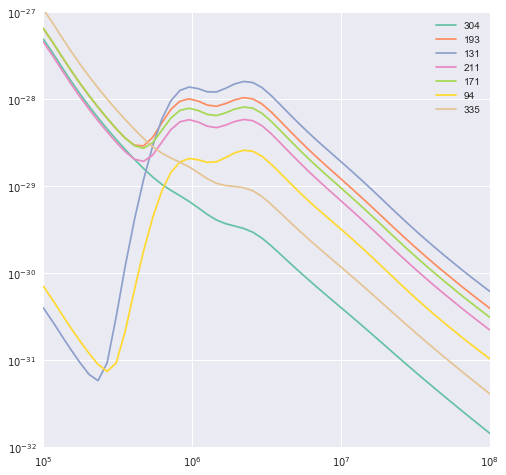

In [91]:
plt.figure(figsize=(8,8))
for channel in continuum_contributions:
    plt.plot(temperature,
             continuum_contributions[channel],
             label=channel,color=channel_colors[channel])
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e5,1e8])
plt.ylim([1e-32,1e-27])
plt.legend(loc='best')

Seems like the factor of $1/4\pi$ is missing from the contribution function, despite what the comments in the IDL code say...neglecting it gives good (almost exact!) agreement in the parts of the response function dominated by line emission

Factor of 0.83 is definitely missing.

Continuum calculation still too small.

TODO:

* re-calculate emission structure from IDL scripts
* re-calculate temperature response functions
* double-check continuum calculations, compare with CHIANTI-IDL results; continuum calculations still too small
* save emissivity info in HDF5 file, separated by ion, $N_{\lambda}\times N_{T}$ array for each ion, continuum contributions as well
* flow chart of how this code works might be helpful...